In [1]:
import numpy as np
import json
from utilities import *
from utilitiesDL import *
from OFDMparam import *
from CFOcorr import *
from getModFeat import *
import random
import os
from glob import glob
from collections import defaultdict

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
pi = math.pi

/home/byk004/miniconda3/envs/cyclo_modul_OFDM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
imgSizePsk = 15
imgSizeQam = 50
coord = 'sph'

SNRVec = np.arange(5, 46, 5, dtype=int)
lowestMod = 'test' # {test, psk, qam}

samplingRate = 20e6
longestPreambleLen = 1200
wlanHTInputSym = 40
wlanHEInputSym = 10
removeNull = True
if lowestMod == 'test' or lowestMod == 'psk':
    angleMod = False
else:
    angleMod = True
if lowestMod == 'test':
    testFlag = True
else:
    testFlag = False

f = open('./inputJson/test.json')
dataPath = json.load(f)['data_path']
print(dataPath)

f = open('./inputJson/class/testClass.json')
classJson = json.load(f)
protocolList = np.array(classJson['protocolList'])
CPOptList = np.array(classJson['CPOptList'], dtype=object)
CPLenList = np.array(classJson['CPLenList'], dtype=object)
modList = np.array(classJson['modList'], dtype=object)

/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHE/


In [5]:
dataDict = {file:[] for file in protocolList}
for i, protocol in enumerate(protocolList):
    dataDict[protocol] = {file:[] for file in CPOptList[i]}
    for CPOpt in CPOptList[i]:
        dataDict[protocol][CPOpt] = {file:[] for file in modList[i]}
        for mod in modList[i]:
            dataDict[protocol][CPOpt][mod] = {file:[] for file in SNRVec}
            for SNR in SNRVec:
                dataDict[protocol][CPOpt][mod][SNR] = defaultdict(list)

for subFolder in os.walk(dataPath):
    dirFilenameList = glob(subFolder[0] + '/*.32cf')
    print(len(dirFilenameList))
    for fileIndex, dirFileName in enumerate(dirFilenameList):
        fileName = dirFileName.split("/")[-1][:-5]
        fileProtocol = (dirFileName.split("/")[-1][:-5]).split("_")[0]
        fileCPOpt = (dirFileName.split("/")[-1][:-5]).split("_")[1]
        fileMod = int((dirFileName.split("/")[-1][:-5]).split("_")[2])
        fileSNR = int((dirFileName.split("/")[-1][:-5]).split("_")[4])

        fileProtocolIndex = int(np.where(protocolList == fileProtocol)[0])
        # print(modList[fileProtocolIndex])
        fileModIndex = int(np.where(np.array(modList[fileProtocolIndex]) == fileMod)[0])
        if lowestMod == 'psk':
            if fileModIndex > 2:
                fileModIndex = 2
        elif lowestMod == 'qam':
            fileModIndex -= 2

        dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['label'].append(fileModIndex)
        load_out = np.fromfile(dirFileName, dtype=np.float32)
        data = load_out[np.arange(0, load_out.shape[0], 2)] +\
            1j * load_out[np.arange(1, load_out.shape[0], 2)]

        if fileProtocol == 'wlanHT':
            nSubC = 64
            if fileCPOpt == 'Normal':
                CPLen = 8
            else:
                CPLen = 16
            preambleLen = 720
            inputLen = (wlanHTInputSym+2) * (nSubC+CPLen)
            nSym = wlanHTInputSym
        elif fileProtocol == 'wlanHE':
            nSubC = 256
            if fileCPOpt == 'Normal':
                CPLen = 16
                preambleLen = 1152
            elif fileCPOpt == 'Medium':
                CPLen = 32
                preambleLen = 1040
            else:
                CPLen = 64
                preambleLen = 1200  
            inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
            nSym = wlanHEInputSym

        inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))
        firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
        inputIQ_CFO = corrCFO(data[inputStartIndex : inputStartIndex+inputLen],\
            nSubC, CPLen, firstIndexTruth, samplingRate, 2)
        feat = getModFeat(inputIQ_CFO, nSubC, CPLen, firstIndexTruth, nSym, removeNull, angleMod)
        feat = np.reshape(feat, (56, 40))
        
        # print('img, ', imgData(feat, imgSize, angleMod).shape)
        if lowestMod == 'psk' or lowestMod == 'test':
            dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizePsk, angleMod))
        else:
            dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['input'].append(imgData(feat, imgSizeQam, angleMod))

        if lowestMod == 'test':
            featMod = getModFeat(inputIQ_CFO, nSubC, CPLen, firstIndexTruth, nSym, removeNull, True)
            dataDict[fileProtocol][fileCPOpt][fileMod][fileSNR]['inputMod'].append(imgData(feat, imgSizeQam, True))
        
for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for mod in modList[i]:
            numFile = 0
            for SNR in SNRVec:
                numFile += len(dataDict[protocol][CPOpt][mod][SNR]['label'])
            print(protocol, CPOpt, str(mod), numFile)


0
450
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16


(50, 50)


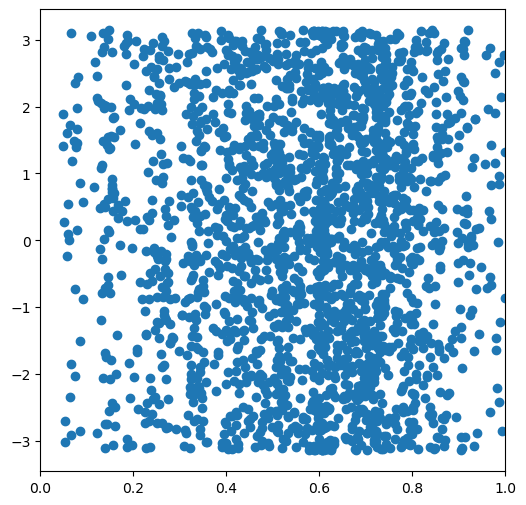

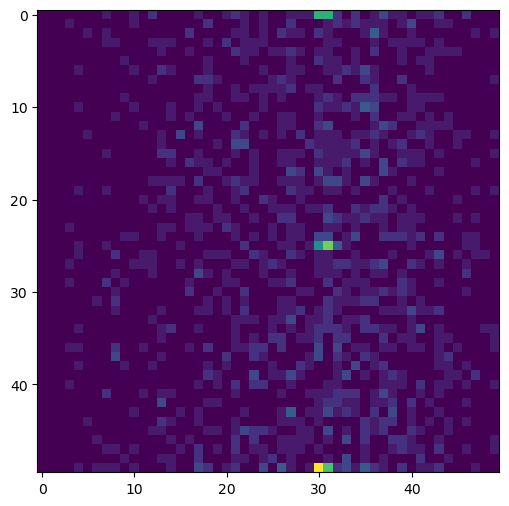

In [4]:
# dataDict['wlanHT']['Extended'][4][30]['input'][0][0, :, :].flatten().shape
# print(feat)
dirFileName = '/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHE/wlanHE_Extended_256qam/wlanHE_Extended_256_0_30_20_0.4_24.32cf'
dirMetadataFile = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHE/wlanHE_Extended_256qam/wlanHE_Extended_256_0_30_20_0.4_24.metadata')
loadMetadata = json.load(dirMetadataFile)

# print(dirFileName)
load_out = np.fromfile(dirFileName, dtype=np.float32)
data = load_out[np.arange(0, load_out.shape[0], 2)] +\
    1j * load_out[np.arange(1, load_out.shape[0], 2)]
# print(data.shape[0])

preambleLen = 1200
nSubC = 256
CPLen = 64
nSym = 10
inputLen = (wlanHEInputSym+2) * (nSubC+CPLen)
inputStartIndex = int(random.randint(longestPreambleLen, data.shape[0]-inputLen))

inputIQ = data[inputStartIndex:inputStartIndex+inputLen]
firstIndexTruth = (-1 * inputStartIndex + preambleLen) % (nSubC+CPLen)
# print(inputIQ.shape[0], inputStartIndex, firstIndexTruth)

CFOtruth = getCFOtruth(loadMetadata)
# print(CFOtruth)
# print(estCFO(inputIQ, nSubC, CPLen, firstIndexTruth, samplingRate))

inputIQ_CFOest = corrCFO(inputIQ, nSubC, CPLen, firstIndexTruth, samplingRate, 2)
feat = getModFeat(inputIQ_CFOest, nSubC, CPLen, firstIndexTruth, nSym, removeNull, False)
imgDataResult = np.squeeze(imgData(feat, imgSizeQam, angleMod))
print(imgDataResult.shape)

feat = torch.from_numpy(feat)

plt.figure(figsize=(6,6))
plt.scatter(torch.divide(torch.abs(feat), torch.max(torch.abs(feat))), torch.angle(feat))
plt.xlim(0, 1)

plt.figure(figsize=(6,6))
plt.imshow(imgDataResult)
# print(horIndexIndicator.shape, verIndexIndicator.shape)
# print(np.max(horIndex), np.max(verIndex), np.min(horIndex), np.min(verIndex))
# print(imgInput.shape, absMax)
# xylim = 0.06
# plt.xlim((-xylim, xylim))
# plt.ylim((-xylim, xylim))

In [18]:
trList = list()
valList = list()
cudaID = 0
batchSize = 32
# trainSNRVec = range(5, 41, 5)
# trainSNRVec = [0, 0, 15, 25, 30, 40]
# trainSNRVec = [0, 0, 0, 0, 0, 0]
SNRThres = 10
trainSNRVec = [SNRThres, SNRThres, SNRThres, SNRThres, SNRThres, SNRThres]

for i, protocol in enumerate(protocolList):
    for CPOpt in CPOptList[i]:
        for iMod, mod in enumerate(modList[i]):
            trDataCount = 0
            valDataCount = 0
            for SNR in SNRVec:
                # dataset = sphDataset(dataDict[protocol][CPOpt][mod][SNR],cuda_id=cudaID)
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],angleMod,testFlag,cuda_id=cudaID)

                if iMod >= 10:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label']) / 2))
                    numTotData = int(np.ceil(len(dataDict[protocol][CPOpt][mod][SNR]['label'] ) / 2))
                else:
                    numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                    numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                if SNR >= trainSNRVec[iMod]:
                    # print(SNR, trainSNRVec[iMod])
                    trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                    valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                # valDataCount += (numTotData - numTrData)

                if SNR < trainSNRVec[iMod]:
                    numTrData = 0
                    numTotData = 0
                # print(protocol, CPOpt, str(mod), numTrData, numTotData)
                trDataCount += numTrData
                valDataCount += (numTotData - numTrData)

            print(protocol, CPOpt, str(mod), trDataCount, valDataCount)

trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
valDataset = torch.utils.data.ConcatDataset(valList)

trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

print('Training data size: '+str(len(trDataset))+' Test data size: '+str(len(valDataset)))

wlanHT Extended 2 0 0
wlanHT Extended 4 0 0
wlanHT Extended 16 0 0
wlanHT Extended 64 0 0
wlanHT Normal 2 0 0
wlanHT Normal 4 0 0
wlanHT Normal 16 0 0
wlanHT Normal 64 0 0
wlanHE Extended 2 0 0
wlanHE Extended 4 0 0
wlanHE Extended 16 320 80
wlanHE Extended 64 320 80
wlanHE Extended 256 320 80
wlanHE Extended 1024 320 80
wlanHE Medium 2 0 0
wlanHE Medium 4 0 0
wlanHE Medium 16 320 80
wlanHE Medium 64 320 80
wlanHE Medium 256 320 80
wlanHE Medium 1024 320 80
wlanHE Normal 2 0 0
wlanHE Normal 4 0 0
wlanHE Normal 16 320 80
wlanHE Normal 64 320 80
wlanHE Normal 256 320 80
wlanHE Normal 1024 320 80
NRDLa Extended 4 0 0
NRDLa Extended 16 0 0
NRDLa Extended 64 0 0
NRDLa Extended 256 0 0
NRDLa Normal 4 0 0
NRDLa Normal 16 0 0
NRDLa Normal 64 0 0
NRDLa Normal 256 0 0
NRDLb Normal 4 0 0
NRDLb Normal 16 0 0
NRDLb Normal 64 0 0
NRDLb Normal 256 0 0
NRDLc Normal 4 0 0
NRDLc Normal 16 0 0
NRDLc Normal 64 0 0
NRDLc Normal 256 0 0
Training data size: 3840 Test data size: 960


In [8]:
# nClass = 6
inputSym = 40
LR = 5e-4
criterion = torch.nn.CrossEntropyLoss()

savePskModelPath = './saveDLModel/candidate/wifiHEImgPskWo45.cpkt'
saveQamModelPath = './saveDLModel/candidate/wifiHEImgQamWo10_p3.cpkt'

if lowestMod == 'psk':
    loadedWifiNet = wifiImgPskNet(3, removeNull)
elif lowestMod == 'qam':
    loadedWifiNet = wifiImgQamNet(4, removeNull)
loadedWifiNet.apply(init_weights)

if cudaID is not None: loadedWifiNet = loadedWifiNet.cuda(cudaID)

opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
loadedWifiNet.train()   # setting training flag


NameError: name 'loadedWifiNet' is not defined

In [20]:
accTrainList = []
accValidList = []
bestAcc = 0.0
patience = 0
fastConvergeFlag = True
nEpoch = 150

if lowestMod == 'psk':
    saveModelPath = savePskModelPath
elif lowestMod == 'qam':
    saveModelPath = saveQamModelPath
print('save model path:', saveModelPath)
torch.set_num_threads(1)
for epoch in range(nEpoch):
    runningLoss = 0.0
    for i, data in enumerate(trLoader):
        # print('train:', i)
        targets = data['target']
        opt.zero_grad()
        trInput = data['input']
        # print(data['input'].shape)

        outputs = loadedWifiNet(trInput)
        loss = criterion(outputs, targets)
        # print('backprop')
        loss.backward()
        opt.step()
        runningLoss += loss.item()

    avgLoss = runningLoss/len(trLoader)
    accTrain = getAcc(trLoader, loadedWifiNet)
    print('epoch: ', epoch, 'train loss: ', round(avgLoss, 4),\
        'accuracy: ', round(accTrain, 4))
    
    # getting valid error
    runningLoss = 0.0
    for i, data in enumerate(valLoader):
        # print('valid:', i)
        labels = data['target']
        validInput = data['input']

        outputs = loadedWifiNet(validInput)
        valLoss = criterion(outputs, labels)
        runningLoss += valLoss.item()

    avgValLoss = runningLoss/len(valLoader)
    accValid = getAcc(valLoader, loadedWifiNet)
    pred_l,target_l = getPreds(valLoader, loadedWifiNet)

    if bestAcc < accValid:
        bestAcc = accValid
        print('saving model')
        torch.save(loadedWifiNet.state_dict(), saveModelPath)  # saving model with best test accuracy
        patience = 0
        
    print('test loss: ', round(avgValLoss, 4), 'test accuracy:', round(accValid, 4))

    accTrainList.append(accTrain)
    accValidList.append(accValid)
    
    # early stopping if the model converges twice
    patience += 1
    if patience > 20:
        if fastConvergeFlag == True:
            LR = LR/10
            opt = torch.optim.Adam(loadedWifiNet.parameters(),lr=LR,weight_decay=0.01)
            fastConvergeFlag = False
            patience = 0
            print('Fast Converge finishes!')
        else:
            break

print('best test accuracy:', round(bestAcc, 4))

save model path: ./saveDLModel/candidate/wifiHEImgQamWo10_p3.cpkt
epoch:  0 train loss:  0.8669 accuracy:  0.6695
saving model
test loss:  0.7391 test accuracy: 0.6677
epoch:  1 train loss:  0.6769 accuracy:  0.7289
saving model
test loss:  0.6281 test accuracy: 0.7073
epoch:  2 train loss:  0.5948 accuracy:  0.751
saving model
test loss:  0.5705 test accuracy: 0.7365
epoch:  3 train loss:  0.5739 accuracy:  0.7474
test loss:  0.5601 test accuracy: 0.7312
epoch:  4 train loss:  0.5455 accuracy:  0.7721
saving model
test loss:  0.5406 test accuracy: 0.7406
epoch:  5 train loss:  0.5232 accuracy:  0.7677
test loss:  0.5359 test accuracy: 0.7385
epoch:  6 train loss:  0.5272 accuracy:  0.7617
saving model
test loss:  0.542 test accuracy: 0.7458
epoch:  7 train loss:  0.5112 accuracy:  0.781
test loss:  0.5197 test accuracy: 0.7438
epoch:  8 train loss:  0.5076 accuracy:  0.7786
saving model
test loss:  0.5212 test accuracy: 0.7469
epoch:  9 train loss:  0.5031 accuracy:  0.7648
test loss:

In [5]:
# print(nClass)
cudaID = 0
batchSize = 32
loadedWifiPskNet = wifiImgPskNet(3, removeNull)
loadedWifiQamNet = wifiImgQamNet(4, removeNull)

if cudaID is not None: loadedWifiPskNet = loadedWifiPskNet.cuda(cudaID)
if cudaID is not None: loadedWifiQamNet = loadedWifiQamNet.cuda(cudaID)

savePskModelPath = './saveDLModel/selected/wifiHEImgPsk_15.cpkt'
saveQamModelPath = './saveDLModel/selected/wifiHEImgQam10_50.cpkt'

# path for saving model
testSNRVec = range(5, 46, 5)
loadedWifiPskNet.load_state_dict(torch.load(savePskModelPath))
loadedWifiQamNet.load_state_dict(torch.load(saveQamModelPath))

trListCumul = list()
valListCumul = list()
for SNR in testSNRVec:
    trList = list()
    valList = list()

    for i, protocol in enumerate(protocolList):
        for CPOpt in CPOptList[i]:
            for mod in modList[i]:
                dataset = imgDataset(dataDict[protocol][CPOpt][mod][SNR],angleMod,testFlag,cuda_id=cudaID)
                
                numTrData = int(np.ceil(0.8*len(dataDict[protocol][CPOpt][mod][SNR]['label'])))
                numTotData = len(dataDict[protocol][CPOpt][mod][SNR]['label'])

                # print(protocol, CPOpt, str(mod), numTrData, numTotData)                
                trList.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valList.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))

                trListCumul.append(torch.utils.data.Subset(dataset,range(numTrData)))
                valListCumul.append(torch.utils.data.Subset(dataset,range(numTrData, numTotData)))
                
    trDataset = torch.utils.data.ConcatDataset(trList) # concatenating dataset lists
    valDataset = torch.utils.data.ConcatDataset(valList)

    trDatasetCumul = torch.utils.data.ConcatDataset(trListCumul) # concatenating dataset lists
    valDatasetCumul = torch.utils.data.ConcatDataset(valListCumul)

    trLoader = DataLoader(trDataset,batch_size=batchSize,shuffle=True)
    valLoader = DataLoader(valDataset,batch_size=batchSize,shuffle=True)

    trLoaderCumul = DataLoader(trDatasetCumul,batch_size=batchSize,shuffle=True)
    valLoaderCumul = DataLoader(valDatasetCumul,batch_size=batchSize,shuffle=True)

    print(len(trDataset), len(valDataset))
    # accTest = getAcc(valLoader, loadedWifiQamNet)
    # accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifi16QamNet, loadedWifi64QamNet, loadedWifi256QamNet)
    accTest = getAccWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)

    print(SNR, accTest)

# accTestCumul = getAcc(valLoaderCumul, loadedWifiQamNet)
# accTestCumul = getAccWifi(valLoaderCumul, loadedWifiPskNet, loadedWifi16QamNet, loadedWifi64QamNet, loadedWifi256QamNet)
accTestCumul = getAccWifi(valLoaderCumul, loadedWifiPskNet, loadedWifiQamNet)
print('cumul:', accTestCumul)

720 180
5 0.5
720 180
10 0.5222222222222223
720 180
15 0.65
720 180
20 0.7722222222222223
720 180
25 0.8388888888888889
720 180
30 0.9
720 180
35 0.95
720 180
40 0.9611111111111111
720 180
45 0.95
cumul: 0.782716049382716


[Text(0, 0, 'BPSK'),
 Text(0, 1, 'QPSK'),
 Text(0, 2, '16QAM'),
 Text(0, 3, '64QAM'),
 Text(0, 4, '256QAM'),
 Text(0, 5, '1024QAM')]

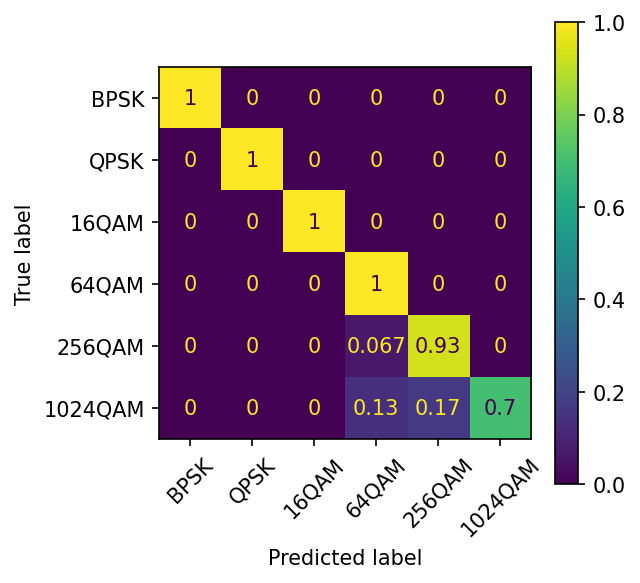

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# pred, target = getPredsWifi(valLoaderCumul, loadedWifiPskNet, loadedWifi16QamNet, loadedWifi64QamNet, loadedWifi256QamNet)
pred, target = getPredsWifi(valLoader, loadedWifiPskNet, loadedWifiQamNet)
# pred, target = getPreds(valLoader, loadedWifiQamNet)

# font = {'size'   : 15}
# plt.rc('font', **font)

cm = confusion_matrix(target,pred,normalize ='true')
for i in range(2):
    for j in range(2):
        cm[i, j] = round(cm[i, j], 2)

# cm[2, 0] = round(cm[2, 0], 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

modNameList = []
for mod in modList[1]:        
    if mod == 2:
        # continue
        modul_name = 'BPSK'
    elif mod == 4:
        # continue
        modul_name = 'QPSK'
    elif mod == 16:
        # continue
        modul_name = '16QAM'
    elif mod == 64:
        # break
        # continue
        modul_name = '64QAM'
    elif mod == 256:
        # break
        modul_name = '256QAM'
    elif mod == 1024:
        # break
        modul_name = '1024QAM'

    modNameList.append(modul_name)
plt_labels = modNameList
ax.set_xticklabels(plt_labels, rotation=45)
ax.set_yticklabels(plt_labels)

In [29]:
SNRVec = np.arange(40, 41, 2, dtype=int)
FFTsize = 4096
tauVec = np.array([64, 256, 512, 1024, 2048])
CPLenList = [[16, 8], [64, 32, 16], [128, 36], [72], [144]]
CPOptList = np.array([np.array(['Extended', 'Normal']   ),\
    np.array(['Extended', 'Medium', 'Normal']),\
    np.array(['Extended', 'Normal']),\
    np.array(['Normal']), np.array(['Normal'])], dtype=object)
protocolList = np.array(['wlanHT', 'wlanHE', 'NRDLa', 'NRDLb', 'NRDLc'])

In [50]:
load_out = np.fromfile('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.32cf',\
    dtype=np.float32)
f = open('/project/iarpa/dataset/cyclo_modul_OFDM/simulation/train/wlanHT/wlanHT_Extended_16qam/wlanHT_Extended_16_0_30_20_0.4_2.metadata')
loadMetadata = json.load(f)

data = load_out[np.arange(0, load_out.shape[0], 2)] +\
                    1j * load_out[np.arange(1, load_out.shape[0], 2)]

In [9]:
from torchsummary import summary
summary(loadedWifiNet, input_size=(1, 50, 50))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.